In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## The Markov Decision Process

In [2]:
ACTIONS = ["SHOOT", "DODGE", "RECHARGE"]
STAMINA = [0, 50, 100]
ARROWS = [0, 1, 2, 3]
DRAGON_HEALTH = [0, 25, 50, 75, 100]

v_table = np.zeros(shape=(5, 4, 3)) # (arrows, stamina, health)
p_table = np.zeros(shape=(5, 4, 3))
q_table = np.zeros(shape=(5, 4, 3, len(ACTIONS)))

In [3]:
STATES = [(h, a, s) for h in range(v_table.shape[0]) 
                    for a in range(v_table.shape[1]) 
                    for s in range(v_table.shape[2])]

In [4]:
INFINTIY = 1e16

def get_next_utility(state: tuple, action: int) -> float:
    """
    Computes the utility of the next state
    """
    assert len(state) == 3 and state[0] < 5 and state[1] < 4 and state[2] < 3 and action < 3
    dragon_health, arrows, stamina = state
    if dragon_health == 0:
        return 0.0
    if ACTIONS[action] == "SHOOT":
        if arrows == 0 or stamina == 0:
            return -INFINTIY
        return 0.5 * v_table[dragon_health, arrows - 1, stamina - 1] + \
               0.5 * v_table[dragon_health - 1, arrows - 1, stamina - 1]
    elif ACTIONS[action] == "DODGE":
        if stamina == 0:
            return -INFINTIY
        elif stamina == 1:
            return 0.8 * v_table[dragon_health, min(arrows + 1, 3), 0] + \
                   0.2 * v_table[dragon_health, arrows, 0]
        elif stamina == 2:
            return 0.8 * 0.8 * v_table[dragon_health, min(arrows + 1, 3), 1] + \
                   0.2 * 0.8 * v_table[dragon_health, arrows, 1] + \
                   0.8 * 0.2 * v_table[dragon_health, min(arrows + 1, 3), 0] + \
                   0.2 * 0.2 * v_table[dragon_health, arrows, 0]
    elif ACTIONS[action] == "RECHARGE":
        return 0.8 * v_table[dragon_health, arrows, min(stamina + 1, 2)] + \
               0.2 * v_table[dragon_health, arrows, stamina]

In [5]:
def get_action_cost(state: tuple, action: int) -> float:
    """
    Returns the reward associated with each action taken
    """
    assert len(state) == 3 and state[0] < 5 and state[1] < 4 and state[2] < 3 and action < 3
    if state[0] == 0:
        return 0.0
    if state[0] == 1 and action == 0:
        return -20.0 + 10.0 * 0.5
    return -20.0 # Penalty = 20 due to Team Number = 9

In [6]:
def check_convergence(old_table: np.ndarray, new_table: np.ndarray, delta: int = 0.001) -> bool:
    """
    Checks if the value iteration algorithm has converged
    """
    assert old_table.shape == new_table.shape
    ans = np.max(np.abs(new_table - old_table)) < delta
    return ans

In [7]:
def random_initialize():
    """
    Randomly assigns values to the v_table and the p_table
    """
    global v_table, q_table, p_table
    v_table = np.random.random(size=v_table.shape)
    q_table = np.zeros(shape=q_table.shape)
    p_table = np.random.choice(range(len(ACTIONS)), size=p_table.shape)

In [8]:
def print_state(iteration: int, v_table: np.ndarray, p_table: np.ndarray, filename = None):
    """
    Prints the entire state in the Value Iteration Algorithm
    """
    assert len(v_table.shape) == len(p_table.shape) == 3
    if filename == None:
        print("iteration=", iteration)
        for h, a, s in STATES:
            print("({0},{1},{2}):{3}=[{4:.3f}]".format(
                h, a, s, 
                ACTIONS[p_table[h][a][s]] if h != 0 else '-1', v_table[h][a][s]))
        print("\n\n")
    else:
        with open(filename, 'a') as f:
            f.write("iteration={}\n".format(iteration))
            for h, a, s in STATES:
                f.write("({0},{1},{2}):{3}=[{4:.3f}]\n".format(
                    h, a, s, 
                    ACTIONS[p_table[h][a][s]] if h != 0 else '-1', v_table[h][a][s]))
            f.write("\n\n")

## The Value Iteration Algorithm

```
Procedure Value_Iteration(S, A, P, R, θ)
    Inputs:
        S is the set of all states
        A is the set of all actions
        P is state transition function specifying P(s'|s,a)
        R is a reward function R(s,a,s')
        θ a threshold, θ > 0$
    Output:
        π[S] approximately optimal policy
        V[S] value function
    Local:
        real array Vk[S] is a sequence of value functions
        action array π[S]
        
    assign V0[S] arbitrarily
    k ← 0
    repeat
       k ← k+1
       for each state s do
           Vk[s] = maxa ∑s' P(s'|s,a) (R(s,a,s')+ γVk-1[s'])
    until ∀s |Vk[s]-Vk-1[s]| < θ
    for each state s do
       π[s] = argmaxa ∑s' P(s'|s,a) (R(s,a,s')+ γVk[s'])
    return π,Vk
```

In [9]:
history_delta = []

def value_iteration(gamma = 0.99):
    """
    Computes the Optimal Policy and the State Values
    """
    global v_table, p_table, q_table
    random_initialize()
    converged = False
    for iteration in range(1, 1000):
        for h, a, s in STATES:
            for act in range(len(ACTIONS)):
                q_table[h, a, s, act] = gamma * get_next_utility((h, a, s), act) \
                                              + get_action_cost((h, a, s), act)
        new_v_table = np.max(q_table, axis=3)
        p_table = np.argmax(q_table, axis=3)
        converged = check_convergence(v_table, new_v_table)
        history_delta.append(np.max(np.abs(new_v_table - v_table)))
        v_table = new_v_table
        print_state(iteration, v_table, p_table, 'outputs/task_1_trace.txt')
        if converged:
            break

In [10]:
value_iteration()

## Checking our Answers

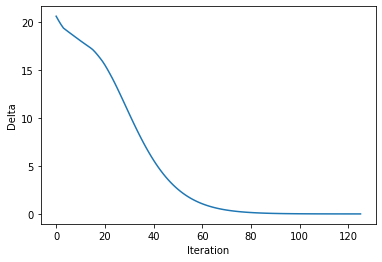

In [11]:
plt.plot(history_delta)
plt.xlabel('Iteration')
plt.ylabel('Delta')
plt.show()

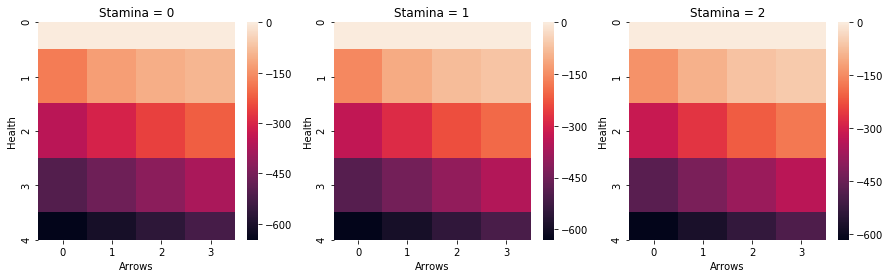

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(v_table[:, :, 0], ax=ax[0])
ax[0].set_title('Stamina = 0')
ax[0].set_xlabel('Arrows')
ax[0].set_ylabel('Health')
sns.heatmap(v_table[:, :, 1], ax=ax[1])
ax[1].set_title('Stamina = 1')
ax[1].set_xlabel('Arrows')
ax[1].set_ylabel('Health')
sns.heatmap(v_table[:, :, 2], ax=ax[2])
ax[2].set_title('Stamina = 2')
ax[2].set_xlabel('Arrows')
ax[2].set_ylabel('Health')
plt.show()

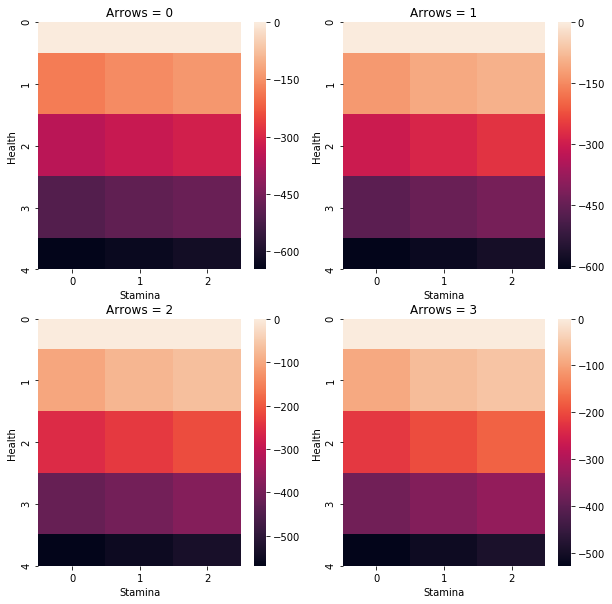

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.heatmap(v_table[:, 0, :], ax=ax[0][0])
ax[0][0].set_title('Arrows = 0')
ax[0][0].set_xlabel('Stamina')
ax[0][0].set_ylabel('Health')
sns.heatmap(v_table[:, 1, :], ax=ax[0][1])
ax[0][1].set_title('Arrows = 1')
ax[0][1].set_xlabel('Stamina')
ax[0][1].set_ylabel('Health')
sns.heatmap(v_table[:, 2, :], ax=ax[1][0])
ax[1][0].set_title('Arrows = 2')
ax[1][0].set_xlabel('Stamina')
ax[1][0].set_ylabel('Health')
sns.heatmap(v_table[:, 3, :], ax=ax[1][1])
ax[1][1].set_title('Arrows = 3')
ax[1][1].set_xlabel('Stamina')
ax[1][1].set_ylabel('Health')

plt.show()

## Final Observations

The graphs and the policy are reasonably obvious, it's better to have more stamina and arrows, and that the Dragon has less health. The actions (shown below) are quite close to the obvious greedy policy (e.g. things like - shoot if you have arrows and dragon is close to dying, dodge if you need arrows or if you have lesser stamina and the dragon is still not close to dying and recharge definitely when you have 0 stamina) since the value function of the game is very smooth.

**Converged Policy Output**
```
iteration=126
(0,0,0):-1=[0.000]
(0,0,1):-1=[0.000]
(0,0,2):-1=[0.000]
(0,1,0):-1=[0.000]
(0,1,1):-1=[0.000]
(0,1,2):-1=[0.000]
(0,2,0):-1=[0.000]
(0,2,1):-1=[0.000]
(0,2,2):-1=[0.000]
(0,3,0):-1=[0.000]
(0,3,1):-1=[0.000]
(0,3,2):-1=[0.000]
(1,0,0):RECHARGE=[-179.508]
(1,0,1):DODGE=[-156.522]
(1,0,2):DODGE=[-137.901]
(1,1,0):RECHARGE=[-127.499]
(1,1,1):SHOOT=[-103.856]
(1,1,2):SHOOT=[-92.478]
(1,2,0):RECHARGE=[-102.076]
(1,2,1):SHOOT=[-78.112]
(1,2,2):SHOOT=[-66.409]
(1,3,0):RECHARGE=[-89.648]
(1,3,1):SHOOT=[-65.527]
(1,3,2):SHOOT=[-53.665]
(2,0,0):RECHARGE=[-351.231]
(2,0,1):DODGE=[-330.413]
(2,0,2):DODGE=[-313.549]
(2,1,0):RECHARGE=[-304.128]
(2,1,1):RECHARGE=[-282.716]
(2,1,2):SHOOT=[-261.033]
(2,2,0):RECHARGE=[-255.680]
(2,2,1):SHOOT=[-233.656]
(2,2,2):SHOOT=[-211.353]
(2,3,0):RECHARGE=[-219.569]
(2,3,1):SHOOT=[-197.089]
(2,3,2):SHOOT=[-174.325]
(3,0,0):RECHARGE=[-506.755]
(3,0,1):DODGE=[-487.901]
(3,0,2):DODGE=[-472.628]
(3,1,0):RECHARGE=[-464.096]
(3,1,1):SHOOT=[-444.703]
(3,1,2):SHOOT=[-425.066]
(3,2,0):RECHARGE=[-420.218]
(3,2,1):DODGE=[-400.271]
(3,2,2):SHOOT=[-380.072]
(3,3,0):RECHARGE=[-375.086]
(3,3,1):RECHARGE=[-354.569]
(3,3,2):SHOOT=[-333.794]
(4,0,0):RECHARGE=[-647.604]
(4,0,1):DODGE=[-630.529]
(4,0,2):DODGE=[-616.697]
(4,1,0):RECHARGE=[-608.970]
(4,1,1):DODGE=[-591.407]
(4,1,2):SHOOT=[-573.623]
(4,2,0):RECHARGE=[-569.232]
(4,2,1):DODGE=[-551.167]
(4,2,2):SHOOT=[-532.874]
(4,3,0):RECHARGE=[-528.358]
(4,3,1):SHOOT=[-509.777]
(4,3,2):SHOOT=[-490.962]
```